# Demo 1: spectral parameterization (FOOOF) + simulation of neural data (neurodsp)
A more comprehensive set of tutorials here: https://fooof-tools.github.io/fooof/auto_tutorials/index.html

If using on Colab, need to run the next line to import the necessary packages

In [1]:
# !pip install fooof

In [2]:
ON_COLAB = False
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np

cur_dir = 'https://raw.githubusercontent.com/rdgao/specparam-sbi/main/demo_notebooks/' if ON_COLAB else './'
plt.style.use(cur_dir + 'matplotlibrc_notebook')

In [3]:
# # generate data
# import fooof
# f_range = [1,500]
# f_res = 0.5
# ap_params = [1,100,3]
# osc_params = [30,1.5,6]
# noise_level = 0.05
# freqs, psd = fooof.sim.gen_power_spectrum(f_range, ap_params, osc_params, noise_level, f_res)
# plt.loglog(freqs, psd)
# np.savez('psd_example', freqs=freqs, psd=psd)

### Load the data: we just need a frequency axis and the power spectrum values.

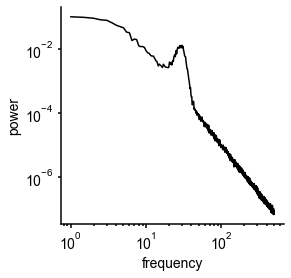

In [4]:
psd_data = np.load('psd_example.npz')
freqs, psd = psd_data['freqs'], psd_data['psd']
plt.loglog(freqs, psd)
plt.xlabel('frequency'); plt.ylabel('power');

### Running FOOOF is literally 2 lines of code.

In [7]:
import fooof
fg = fooof.FOOOF(max_n_peaks=3, min_peak_height=.5, aperiodic_mode='knee')
fg.fit(freqs, psd, freq_range=[1,200])


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



### A report is automatically produced to show the model fit, and various estimated parameters and errors.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 200 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset,

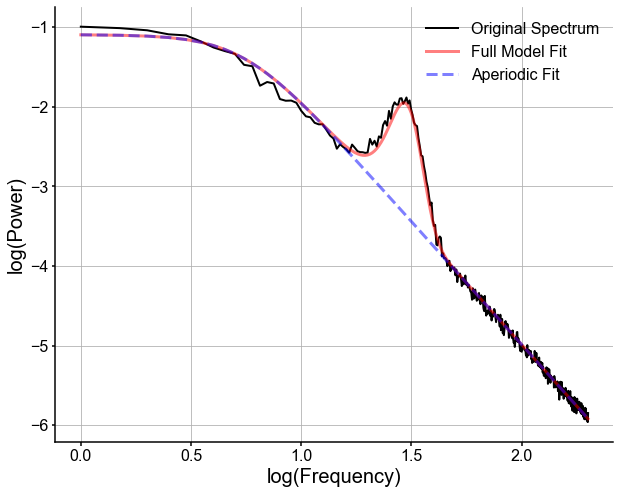

In [8]:
fg.report(plt_log=True)

In [9]:
fg.print_results()

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 200 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     1.2012, 197.0036, 3.0944                                     
                                                                                                  
                                       1 peaks were found:                                        
          

### We can plot the two fitted components separately.

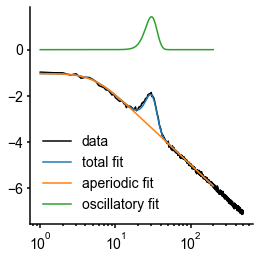

In [78]:
plt.plot(freqs, np.log10(psd), label='data')
plt.plot(fg.freqs, fg.fooofed_spectrum_, label='total fit')
plt.plot(fg.freqs, fg._ap_fit, label='aperiodic fit')
plt.plot(fg.freqs, fg._peak_fit, label='oscillatory fit')
plt.xscale('log')
plt.legend()

### We can also extract the fit paramters in a numpy array for further analyses.

In [79]:
fg.get_results()

FOOOFResults(aperiodic_params=array([  1.146295  , 152.36632624,   3.0679162 ]), peak_params=array([[30.18177013,  1.42664618, 10.79075234]]), r_squared=0.9982286361515991, error=0.04339392319902347, gaussian_params=array([[30.18177013,  1.42745604,  5.39537617]]))

In [80]:
for p in [fg.aperiodic_params_, fg.gaussian_params_, fg.error_, fg.r_squared_]:
    print(p)

[  1.146295   152.36632624   3.0679162 ]
[[30.18177013  1.42745604  5.39537617]]
0.04339392319902347
0.9982286361515991


# We can also start from (simulated) time series.

In [81]:
from neurodsp import sim
from scipy import signal

In [82]:
# Settings for simulation time.
n_seconds = 60
fs = 1000
t_ker=1.

# Exc parameters
n_neurons_E = 1000
firing_rate_E = 1
tau_r_E=0.0
tau_d_E=0.05

# simulating the LFP from just one population
t = np.arange(0,n_seconds, 1/fs)
aperiodic = sim.sim_synaptic_current(n_seconds, fs, n_neurons_E, firing_rate_E, tau_r_E, tau_d_E, t_ker)
periodic = sim.sim_oscillation(n_seconds, fs, 60, 'asine', rdsym=0.75)*0.1 # sprinkle a little oscillation too
lfp = aperiodic + periodic

### Plot the time series and PSD.

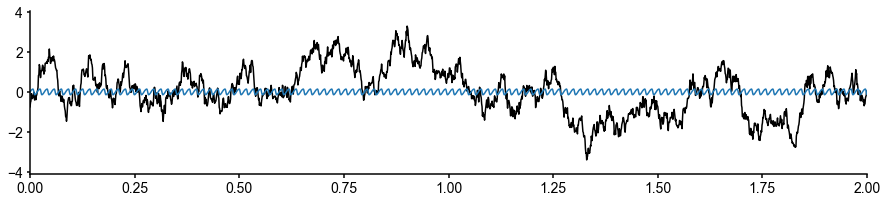

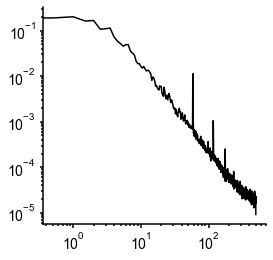

In [86]:
plt.figure(figsize=(15,3))
plt.plot(t,lfp)
plt.plot(t,periodic)
plt.xlim([0,2])

plt.figure()
freqs, psd = signal.welch(lfp, fs=fs, nperseg=fs*2, noverlap=fs, window='hamming')
plt.loglog(freqs, psd)


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  

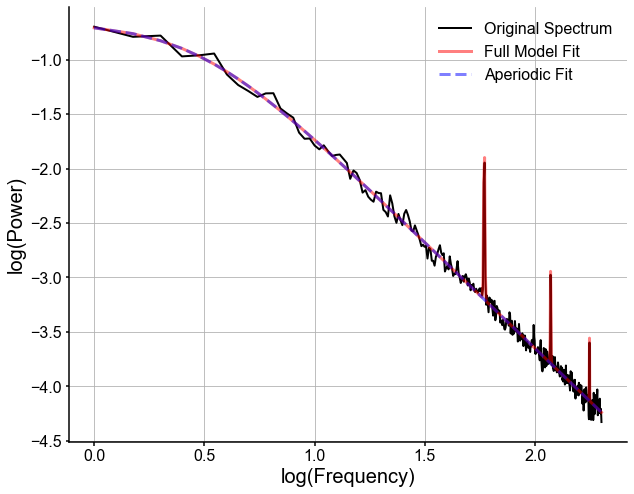

In [87]:
fg = fooof.FOOOF(max_n_peaks=3, min_peak_height=.5, aperiodic_mode='knee')
fg.fit(freqs, psd, freq_range=[1,200])
fg.report(plt_log=True)